## Elo Merchant Category Recommendation - User Loyalty Prediction

### Hsing-Yi Wang, Yi-Ying Peng

##### Mar. 14, 2019

## 1. Introduction, Motivation

> * The data comes from a Kaggle challenge: https://www.kaggle.com/c/elo-merchant-category-recommendation 
> * Desciption of the challenge: Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders.
> * Objective: Develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty.
> * Motivation: Recommendation system  is a very powerful tool for e commerce nowadays. The secret to attract customers or encourage customers to purchase more  lies in knowing customer’s preference from their behaviors. 

## Import Library

In [4]:
install.packages("dummies")
install.packages("fastDummies")
install.packages('tidyverse')
install.packages("RColorBrewer")
install.packages('readr')
install.packages('Metrics')
install.packages("fastDummies")
install.packages('anytime')

In [2]:
library(readr)
library(dplyr)
library(dummies)
library(fastDummies)
library(tidyverse)
library("RColorBrewer")
library(repr)
library(lubridate)
library(ggplot2)
library(scales)
library(Metrics)
library(fastDummies)
library(anytime)

## Load Data

In [4]:
historical_transactions <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/historical_transactions.csv")
merchants <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/merchants.csv")
new_merchant_transactions <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/new_merchant_transactions.csv")
sample_submission <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/sample_submission.csv")
test <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/test.csv")
train <- read_csv("/Users/eve7947/Downloads/elo-merchant-category-recommendation/train.csv")

## 2. Describe Data

### 2.1 Training Data

**Trainin Data: Contains the card_id used for training, and loyalty score which is our dependent variables.**

In [5]:
#Ensure we have read the data into train
glimpse(train)

Observations: 201,917
Variables: 6
$ first_active_month <chr> "2017-06", "2017-01", "2016-08", "2017-09", "201...
$ card_id            <chr> "C_ID_92a2005557", "C_ID_3d0044924f", "C_ID_d639...
$ feature_1          <dbl> 5, 4, 2, 4, 1, 4, 3, 3, 2, 2, 5, 2, 5, 2, 3, 2, ...
$ feature_2          <dbl> 2, 1, 2, 3, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, ...
$ feature_3          <dbl> 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, ...
$ target             <dbl> -0.82028260, 0.39291325, 0.68805599, 0.14249520,...


In [6]:
#Check data type of each variable
sapply(train,class)

first_active_month            card_id          feature_1          feature_2 
       "character"        "character"          "numeric"          "numeric" 
         feature_3             target 
         "numeric"          "numeric"

In [7]:
#Statistic summary of each variable
summary(train)

 first_active_month   card_id            feature_1       feature_2    
 Length:201917      Length:201917      Min.   :1.000   Min.   :1.000  
 Class :character   Class :character   1st Qu.:2.000   1st Qu.:1.000  
 Mode  :character   Mode  :character   Median :3.000   Median :2.000  
                                       Mean   :3.105   Mean   :1.745  
                                       3rd Qu.:4.000   3rd Qu.:2.000  
                                       Max.   :5.000   Max.   :3.000  
   feature_3          target         
 Min.   :0.0000   Min.   :-33.21928  
 1st Qu.:0.0000   1st Qu.: -0.88311  
 Median :1.0000   Median : -0.02344  
 Mean   :0.5656   Mean   : -0.39364  
 3rd Qu.:1.0000   3rd Qu.:  0.76545  
 Max.   :1.0000   Max.   : 17.96507  

#### Note: There is a total of 6 features:
* **card_id** - card identifier
* **first_active_month** - 'YYYY-MM', month of first purchase
* **feature_1** - anonymized card categorical feature
* **feature_2** - anonymized card categorical feature
* **feature_3** - anonymized card categorical feature
* **target** - score of user loyalty

##### -Let's see the distribution of feature1-3

In [11]:
unique(train$feature_1)
unique(train$feature_2)
unique(train$feature_3)

[1] 5 4 2 1 3

[1] 2 1 3

[1] 1 0

**Note: Per checking unique values, we can make sure the features are categorical features, so we choose bar plot to show the distribution.**

In [8]:
#Resigzing plot
options(repr.plot.width=8, repr.plot.height=3)

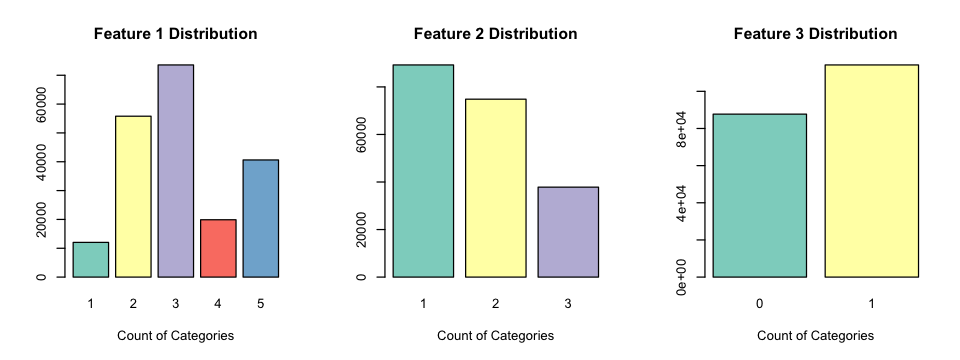

In [9]:
#Plot the distrivution of categorical features
par(mfrow=c(1,3))
counts1 <- table(train$feature_1)
counts2 <- table(train$feature_2)
counts3 <- table(train$feature_3)
barplot(counts1, col=brewer.pal(n=5, name="Set3"), main="Feature 1 Distribution", xlab="Count of Categories")
barplot(counts2, col=brewer.pal(n=3, name="Set3"), main="Feature 2 Distribution", xlab="Count of Categories")
barplot(counts3, col=brewer.pal(n=3, name="Set3"), main="Feature 3 Distribution", xlab="Count of Categories")

**Note: Not much bias on categories of each feature.**

##### -Let's see the distribution of target

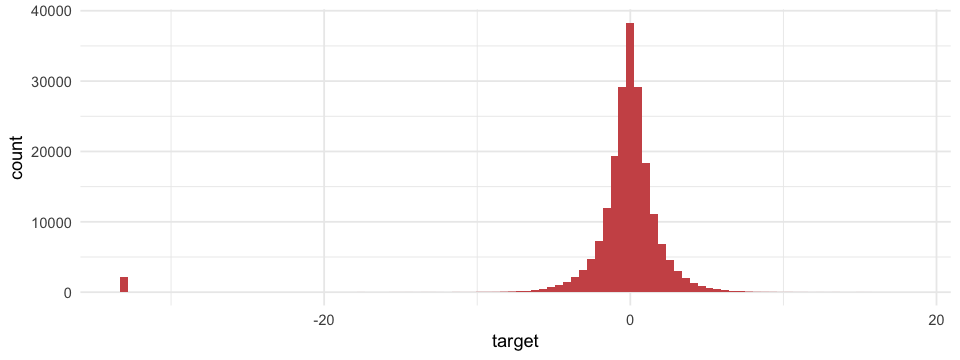

In [13]:
#Distribution of target
options(repr.plot.width=8, repr.plot.height=3)
train %>% 
ggplot(aes(target)) + geom_histogram(bins = 100, fill = "indianred3") + theme_minimal()

**Note: From the histogram it is clear that there outliers less than -30. We need to further check if they are outliers we want to remove.**

### 2.2 Testing Data

**Testing Data: Contains the card_id used for prediction.**

In [14]:
summary(test)

 first_active_month   card_id            feature_1       feature_2    
 Length:123623      Length:123623      Min.   :1.000   Min.   :1.000  
 Class :character   Class :character   1st Qu.:2.000   1st Qu.:1.000  
 Mode  :character   Mode  :character   Median :3.000   Median :2.000  
                                       Mean   :3.109   Mean   :1.742  
                                       3rd Qu.:4.000   3rd Qu.:2.000  
                                       Max.   :5.000   Max.   :3.000  
   feature_3     
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :1.0000  
 Mean   :0.5644  
 3rd Qu.:1.0000  
 Max.   :1.0000  

**Note: Testing Data hsa the same features as training but without target**

##### -Let's see the distribution of feature1-3

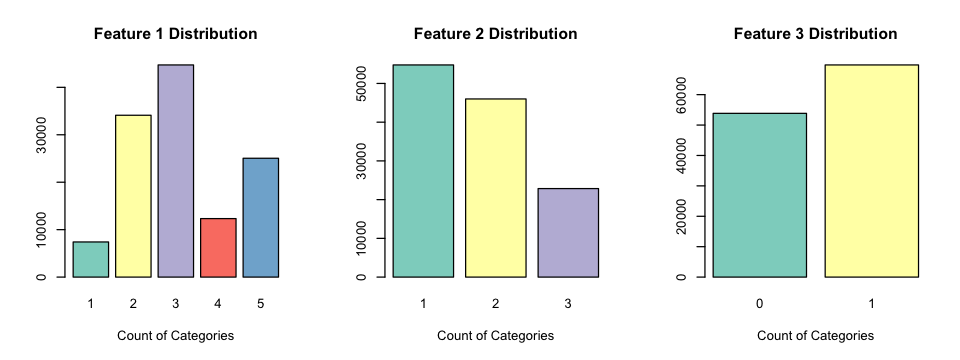

In [15]:
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow=c(1,3))
counts1 <- table(test$feature_1)
counts2 <- table(test$feature_2)
counts3 <- table(test$feature_3)
barplot(counts1, col=brewer.pal(n=5, name="Set3"), main="Feature 1 Distribution", xlab="Count of Categories")
barplot(counts2, col=brewer.pal(n=3, name="Set3"), main="Feature 2 Distribution", xlab="Count of Categories")
barplot(counts3, col=brewer.pal(n=3, name="Set3"), main="Feature 3 Distribution", xlab="Count of Categories")

**Note: Almost identical distributions between train and test data.**

##### - Let's plot how the dates of the first purchases are distributed in both training and testing data

Warning message:
“Removed 1 rows containing non-finite values (stat_count).”

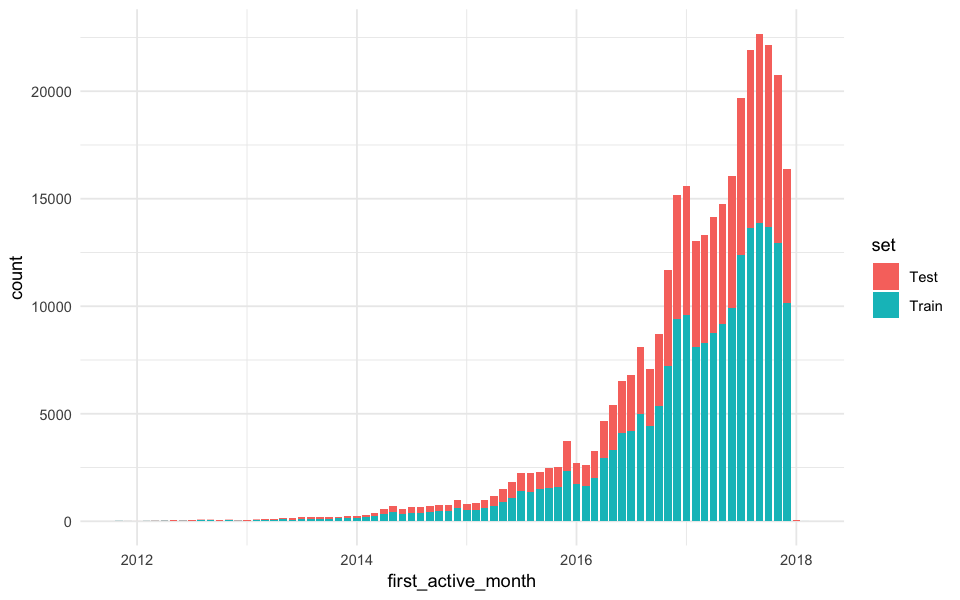

In [16]:
#Plot how the dates of the first purchases are distributed
options(repr.plot.width=8, repr.plot.height=5)
train %>% 
bind_rows(test) %>% 
mutate(set = factor(if_else(is.na(target), "Test", "Train")),
       first_active_month = ymd(first_active_month, truncated = 1)) %>% 
ggplot(aes(x = first_active_month, fill = set)) + geom_bar() + theme_minimal()

**Note: The distributions are quite similar - this makes cross-validation easier.**

### 2.3 Historical & New Merchant Transactions

#### Historrical & New Merchant Transactions:
* **Historical transaction contains up to 3 months' worth of transactions for every card.**
* **Contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) over a period of two months.**

In [27]:
htrans <- historical_transactions
glimpse(htrans)

Observations: 29,112,361
Variables: 14
$ authorized_flag      <chr> "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "...
$ card_id              <chr> "C_ID_4e6213e9bc", "C_ID_4e6213e9bc", "C_ID_4e...
$ city_id              <dbl> 88, 88, 88, 88, 88, 333, 88, 3, 88, 88, 88, -1...
$ category_1           <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", "...
$ installments         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ category_3           <chr> "A", "A", "A", "A", "A", "A", "A", "A", "A", "...
$ merchant_category_id <dbl> 80, 367, 80, 560, 80, 80, 278, 80, 80, 80, 683...
$ merchant_id          <chr> "M_ID_e020e9b302", "M_ID_86ec983688", "M_ID_97...
$ month_lag            <dbl> -8, -7, -6, -5, -11, 0, -11, -3, -8, -11, -9, ...
$ purchase_amount      <dbl> -0.7033309, -0.7331285, -0.7203860, -0.7353524...
$ purchase_date        <dttm> 2017-06-25 15:33:07, 2017-07-15 12:10:45, 201...
$ category_2           <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, NA, 1, 1, 1, ...
$ state_id   

In [18]:
ntrans <- new_merchant_transactions
glimpse(ntrans)

Observations: 1,963,031
Variables: 14
$ authorized_flag      <chr> "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "...
$ card_id              <chr> "C_ID_415bb3a509", "C_ID_415bb3a509", "C_ID_41...
$ city_id              <dbl> 107, 140, 330, -1, -1, 231, 69, 231, 69, 69, 6...
$ category_1           <chr> "N", "N", "N", "Y", "Y", "N", "N", "N", "N", "...
$ installments         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, ...
$ category_3           <chr> "B", "B", "B", "B", "B", "B", "B", "B", "B", "...
$ merchant_category_id <dbl> 307, 307, 507, 661, 166, 367, 333, 307, 278, 4...
$ merchant_id          <chr> "M_ID_b0c793002c", "M_ID_88920c89e8", "M_ID_ad...
$ month_lag            <dbl> 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2...
$ purchase_amount      <dbl> -0.5575737, -0.5695799, -0.5510372, -0.6719255...
$ purchase_date        <dttm> 2018-03-11 14:57:36, 2018-03-19 18:53:37, 201...
$ category_2           <dbl> 1, 1, 1, NA, NA, 1, 1, 1, 1, 1, 1, 1, 1, 1, NA...
$ state_id    

**Note: history transaction and new merchant transaction contain the same features.**

In [19]:
sapply(htrans,class)

$authorized_flag
[1] "character"

$card_id
[1] "character"

$city_id
[1] "numeric"

$category_1
[1] "character"

$installments
[1] "numeric"

$category_3
[1] "character"

$merchant_category_id
[1] "numeric"

$merchant_id
[1] "character"

$month_lag
[1] "numeric"

$purchase_amount
[1] "numeric"

$purchase_date
[1] "POSIXct" "POSIXt" 

$category_2
[1] "numeric"

$state_id
[1] "numeric"

$subsector_id
[1] "numeric"

In [20]:
summary(htrans)

 authorized_flag      card_id             city_id       category_1       
 Length:29112361    Length:29112361    Min.   : -1.0   Length:29112361   
 Class :character   Class :character   1st Qu.: 53.0   Class :character  
 Mode  :character   Mode  :character   Median : 90.0   Mode  :character  
                                       Mean   :129.3                     
                                       3rd Qu.:212.0                     
                                       Max.   :347.0                     
                                                                         
  installments       category_3        merchant_category_id merchant_id       
 Min.   : -1.0000   Length:29112361    Min.   : -1          Length:29112361   
 1st Qu.:  0.0000   Class :character   1st Qu.:307          Class :character  
 Median :  0.0000   Mode  :character   Median :454          Mode  :character  
 Mean   :  0.6485                      Mean   :481                            
 3rd Qu.:  1.

#### There is a total of 14 features:
* **card_id** - card identifier
* **month_lag** - month lag to reference date
* **purchase_date** - 'YYYY-mm-dd'purchase date
* **authorized_flag** - ‘Y’ if approved, ‘N’ if denied
* **category_3** - anonymized categorical
* **installments** -  number of installments of purchase
* **category_1** - anonymized category
* **merchant_category_id** - merchant category identifier (anonymized)
* **subsector_id** - merchant category group identifier (anonymized)
* **merchant_id** - merchant identifier (anonymized)
* **purchase_amount** - normalized purchase amount
* **city_id** - city identifier (anonymized)
* **state_id** - state identifier (anonymized)
* **category_2** - anonymized category

##### -Why is there much more data than train data?

In [32]:
length(unique(htrans$card_id))

[1] 325540

In [33]:
htrans %>% count(card_id) %>% filter(n==max(n)) 

card_id,n
C_ID_3d3dfdc692,5582


In [52]:
htrans %>% count(card_id) %>% top_n(n=10)

Selecting by n


card_id,n
C_ID_0cd2ce025c,2912
C_ID_272aa0597a,1647
C_ID_3d3dfdc692,5582
C_ID_5ccc07beb9,2066
C_ID_5ea401d358,1786
C_ID_6ae9f40da5,1665
C_ID_80c1c711c9,1593
C_ID_9f63809b99,1634
C_ID_9f81506906,1665
C_ID_cc3d4cd4e3,2143


**Note: There are more than on transaction for one card_id, and some of the card_id have more transaction than others.**

##### -Let's Plot the distribution of categorical variables

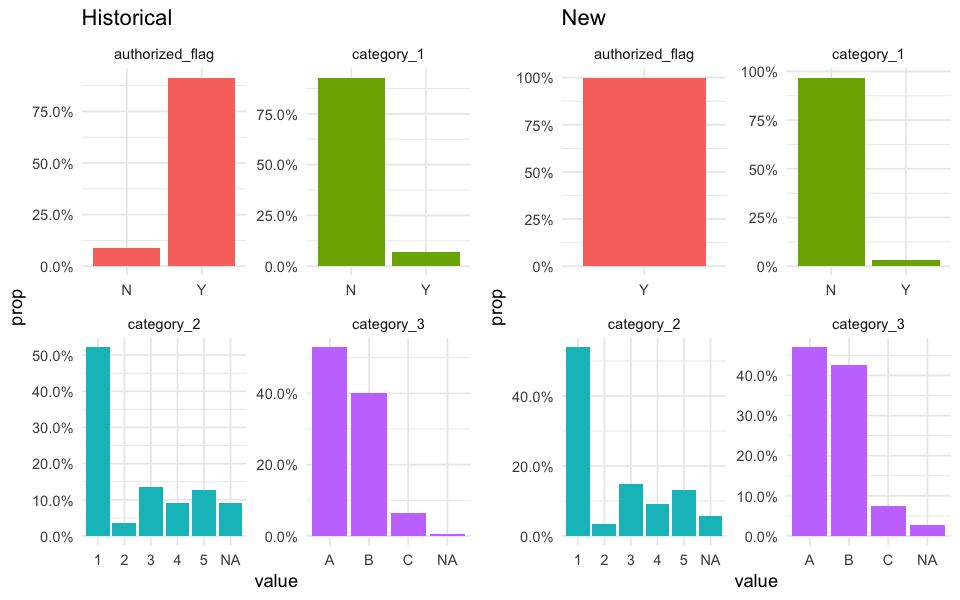

In [23]:
options(repr.plot.width=8, repr.plot.height=3)
p1 <- htrans %>%
  sample_n(6e6) %>% 
  select(authorized_flag, category_1, category_2, category_3) %>% 
  mutate(category_2 = as.character(category_2)) %>% 
  gather(key = "feature", value = "value") %>% 
  mutate(value = factor(value)) %>% 
  ggplot(aes(value, fill = feature)) +
  geom_bar(aes(y = ..prop.., group = 1)) +
  scale_y_continuous(labels = percent_format()) + 
  facet_wrap(~ feature, scales = "free") +
  theme_minimal() +
  ggtitle("Historical") +
  theme(legend.position = "none")
p2 <- ntrans %>%
  select(authorized_flag, category_1, category_2, category_3) %>% 
  mutate(category_2 = as.character(category_2)) %>% 
  gather(key = "feature", value = "value") %>% 
  mutate(value = factor(value)) %>% 
  ggplot(aes(value, fill = feature)) +
  geom_bar(aes(y = ..prop.., group = 1)) +
  scale_y_continuous(labels = percent_format()) + 
  facet_wrap(~ feature, scales = "free") +
  theme_minimal() +
  ggtitle("New") +
  theme(legend.position = "none")
options(repr.plot.width=8, repr.plot.height=5)
source("http://peterhaschke.com/Code/multiplot.R")
multiplot(p1, p2, cols = 2)

**Note: authorized_flag and cateory_1 may not be good features to identify user's preference.**

##### -Lets plot the purchases distributed in time.

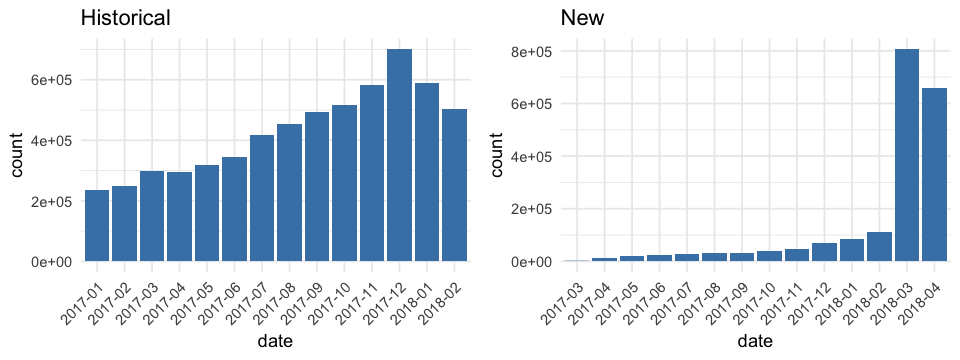

In [29]:
options(repr.plot.width=8, repr.plot.height=5)
p1 <- htrans %>%
  sample_n(6e6) %>% 
  mutate(date = format(purchase_date, "%Y-%m")) %>% 
  ggplot(aes(x = date)) +
  geom_bar(fill = "steelblue") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Historical")
p2 <- ntrans %>%
  mutate(date = format(purchase_date, "%Y-%m")) %>% 
  ggplot(aes(x = date)) +
  geom_bar(fill = "steelblue") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("New")
options(repr.plot.width=8, repr.plot.height=3)
multiplot(p1, p2, cols=2)

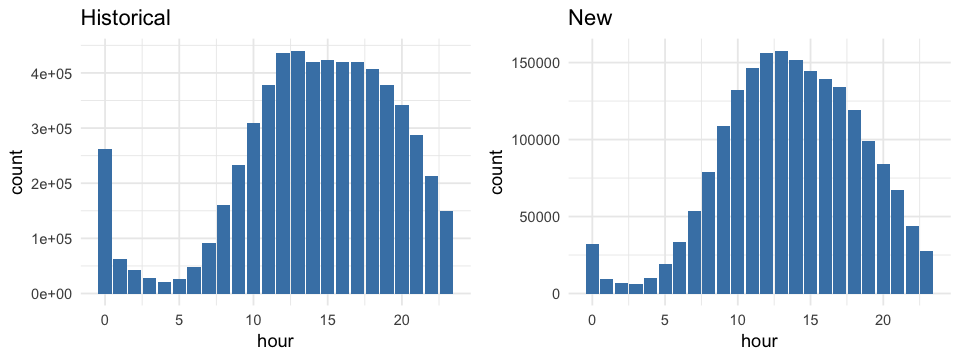

In [30]:
p1 <- htrans %>% 
  sample_n(6e6) %>% 
  mutate(hour = hour(purchase_date)) %>% 
  ggplot(aes(x = hour)) +
  geom_bar(fill = "steelblue") +
  theme_minimal() +
  ggtitle("Historical")
p2 <- ntrans %>% 
  mutate(hour = hour(purchase_date)) %>% 
  ggplot(aes(x = hour)) +
  geom_bar(fill = "steelblue") +
  theme_minimal() +
  ggtitle("New")
options(repr.plot.width=8, repr.plot.height=3)
multiplot(p1, p2, cols=2)

**Note: The most popular season is Christmas. The most unpopular hours for purchases are from 1 to 6.**

### 2.4 Merchant

**Contains aggregate information for each merchant_id**

In [37]:
summary(merchants)

 merchant_id        merchant_group_id merchant_category_id  subsector_id  
 Length:334696      Min.   :     1    Min.   : -1.0        Min.   :-1.00  
 Class :character   1st Qu.:  3612    1st Qu.:222.0        1st Qu.:19.00  
 Mode  :character   Median : 19900    Median :373.0        Median :27.00  
                    Mean   : 31029    Mean   :423.1        Mean   :25.12  
                    3rd Qu.: 51707    3rd Qu.:683.0        3rd Qu.:33.00  
                    Max.   :112586    Max.   :891.0        Max.   :41.00  
                                                                          
  numerical_1         numerical_2         category_1       
 Min.   : -0.05747   Min.   : -0.05747   Length:334696     
 1st Qu.: -0.05747   1st Qu.: -0.05747   Class :character  
 Median : -0.05747   Median : -0.05747   Mode  :character  
 Mean   :  0.01148   Mean   :  0.00810                     
 3rd Qu.: -0.04756   3rd Qu.: -0.04756                     
 Max.   :183.73511   Max.   :182.07932  

#### There is a total of 22 features:

* **merchant_id**	- unique merchant identifier
* **merchant_group_id**	- merchant group (anonymized )
* **merchant_category_id** - unique identifier for merchant category (anonymized )
* **subsector_id** - merchant category group (anonymized )
* **numerical_1** - anonymized measure
* **numerical_2** - anonymized measure
* **category_1** - anonymized category
* **most_recent_sales_range** - range of revenue (monetary units) in last active month --> A > B > C > D > E
* **most_recent_purchases_range** - range of quantity of transactions in last active month --> A > B > C > D > E
* **avg_sales_lag3** - monthly average of revenue in last 3 months divided by revenue in last active month
* **avg_purchases_lag3** - monthly average of transactions in last 3 months divided by transactions in last active month
* **active_months_lag3** - quantity of active months within last 3 months
* **avg_sales_lag6** - monthly average of revenue in last 6 months divided by revenue in last active month
* **avg_purchases_lag6** - monthly average of transactions in last 6 months divided by transactions in last active month
* **active_months_lag6** - quantity of active months within last 6 months
* **avg_sales_lag12** - monthly average of revenue in last 12 months divided by revenue in last active month
* **avg_purchases_lag12** - monthly average of transactions in last 12 months divided by transactions in last active month
* **active_months_lag12** - quantity of active months within last 12 months
* **category_4** - anonymized category
* **city_id** - city identifier (anonymized )
* **state_id** - sState identifier (anonymized )
* **category_2** - anonymized category


Warning message:
“Removed 504218 rows containing non-finite values (stat_density).”

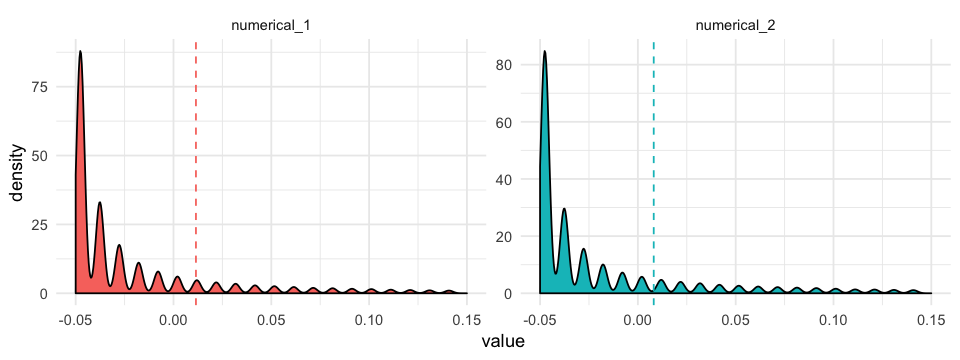

In [31]:
merchants %>%
  select(contains("num")) %>% 
  gather(key = "feature", value = "value", factor_key = TRUE) %>% 
  mutate(value = ifelse(is.infinite(value), NA, value)) %>% 
  group_by(feature) %>% 
  mutate(mean = mean(value, na.rm = TRUE)) %>% 
  ungroup() %>% 
  ggplot(aes(x = value, fill = feature)) +
  geom_density() +
  geom_vline(aes(xintercept = mean, colour = feature), linetype = "dashed") +
  scale_x_continuous(limits=c(-0.05, 0.15)) + 
  facet_wrap(~ feature, scales = "free") +
  theme_minimal() +
  theme(legend.position = "none")

Warning message:
“Removed 707712 rows containing non-finite values (stat_density).”

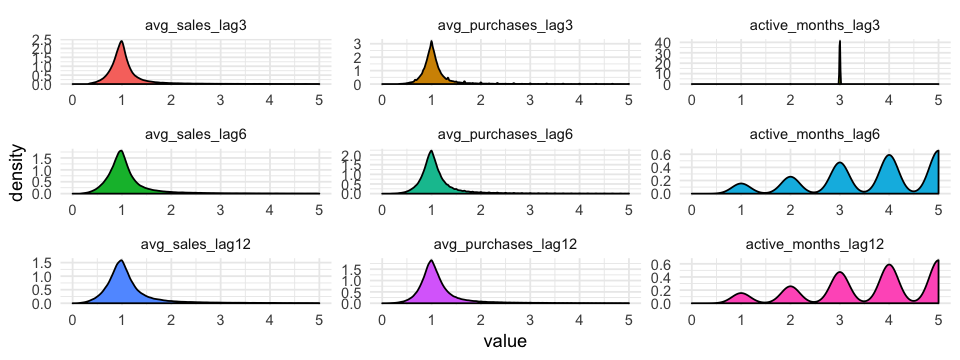

In [34]:
merchants %>%
  select(contains("lag")) %>% 
  gather(key = "feature", value = "value", factor_key = TRUE) %>% 
  mutate(value = ifelse(is.infinite(value), NA, value)) %>% 
  ggplot(aes(x = value, fill = feature)) +
  geom_density() +
  scale_x_continuous(limits=c(0, 5)) + 
  facet_wrap(~ feature, scales = "free") +
  theme_minimal() +
  theme(legend.position = "none")

## 3. Prepare Data

### 3.1 Prepare Training Data to Apply Linear Regresion on Features of Training Data

##### -Check NA

In [38]:
sum(is.na(train))

[1] 0

**Note: There is no missing value in the data**

##### -Check if there is data from the same customer

In [39]:
length(unique(train$card_id))

[1] 201917

In [40]:
length(train$card_id)

[1] 201917

**Note: There is no training data from the same customer**

##### -Check Outliers

In [41]:
sum(train$target < -30)

[1] 2207

In [43]:
train %>% select(card_id, target) %>% filter(target < -30) %>% head()

card_id,target
C_ID_8186f3fcc1,-33.21928
C_ID_b9379a30ea,-33.21928
C_ID_e9120f535c,-33.21928
C_ID_65715cb80d,-33.21928
C_ID_ae77d244b6,-33.21928
C_ID_c4262c902e,-33.21928


##### -Check the Distribution of Features amount Outliers

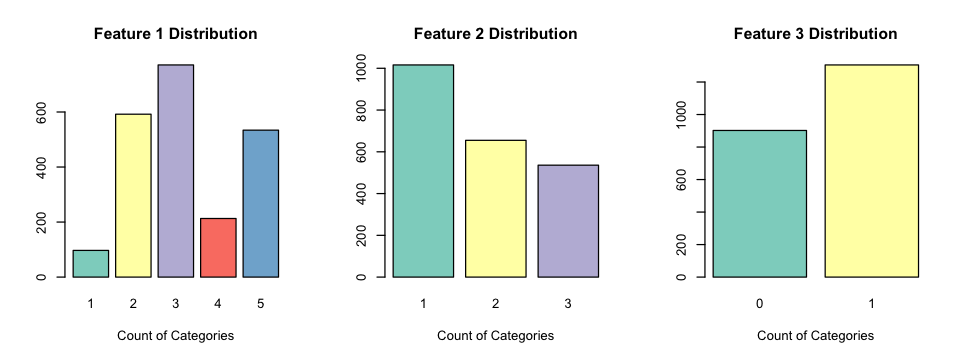

In [44]:
train_outliers = train[train$target < -30,]
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow=c(1,3))
counts1 <- table(train_outliers$feature_1)
counts2 <- table(train_outliers$feature_2)
counts3 <- table(train_outliers$feature_3)
barplot(counts1, col=brewer.pal(n=5, name="Set3"), main="Feature 1 Distribution", xlab="Count of Categories")
barplot(counts2, col=brewer.pal(n=3, name="Set3"), main="Feature 2 Distribution", xlab="Count of Categories")
barplot(counts3, col=brewer.pal(n=3, name="Set3"), main="Feature 3 Distribution", xlab="Count of Categories")

**Note: Outliers have quite different features, so we should not remove them**

##### -Change categorial variables into dummy variables

In [45]:
train_feature_dummy <-fastDummies::dummy_cols(train, select_columns = c("feature_1","feature_2","feature_3"))
head(train_feature_dummy)

first_active_month,card_id,feature_1,feature_2,feature_3,target,feature_1_5,feature_1_4,feature_1_2,feature_1_1,feature_1_3,feature_2_2,feature_2_1,feature_2_3,feature_3_1,feature_3_0
2017-06,C_ID_92a2005557,5,2,1,-0.8202826,1,0,0,0,0,1,0,0,1,0
2017-01,C_ID_3d0044924f,4,1,0,0.3929132,0,1,0,0,0,0,1,0,0,1
2016-08,C_ID_d639edf6cd,2,2,0,0.6880560,0,0,1,0,0,1,0,0,0,1
2017-09,C_ID_186d6a6901,4,3,0,0.1424952,0,1,0,0,0,0,0,1,0,1
2017-11,C_ID_cdbd2c0db2,1,3,0,-0.1597492,0,0,0,1,0,0,0,1,0,1
2016-09,C_ID_0894217f2f,4,2,0,0.8715853,0,1,0,0,0,1,0,0,0,1


##### -Change date into dummy variables by aggregating same month. Remove original feature and date variables

In [46]:
train_feature_dummy$first_active_month = format(anytime(train_feature_dummy$first_active_month), "%m")
train_feature_month_dummy <-fastDummies::dummy_cols(train_feature_dummy, select_columns = "first_active_month")
train_feature_month_dummy = train_feature_month_dummy[ , !(names(train_feature_month_dummy) %in% c("first_active_month", "feature_1", "feature_2", "feature_3"))]
head(train_feature_month_dummy)

card_id,target,feature_1_5,feature_1_4,feature_1_2,feature_1_1,feature_1_3,feature_2_2,feature_2_1,feature_2_3,⋯,first_active_month_08,first_active_month_09,first_active_month_11,first_active_month_12,first_active_month_10,first_active_month_03,first_active_month_04,first_active_month_02,first_active_month_07,first_active_month_05
C_ID_92a2005557,-0.8202826,1,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
C_ID_3d0044924f,0.3929132,0,1,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
C_ID_d639edf6cd,0.6880560,0,0,1,0,0,1,0,0,⋯,1,0,0,0,0,0,0,0,0,0
C_ID_186d6a6901,0.1424952,0,1,0,0,0,0,0,1,⋯,0,1,0,0,0,0,0,0,0,0
C_ID_cdbd2c0db2,-0.1597492,0,0,0,1,0,0,0,1,⋯,0,0,1,0,0,0,0,0,0,0
C_ID_0894217f2f,0.8715853,0,1,0,0,0,1,0,0,⋯,0,1,0,0,0,0,0,0,0,0


## 4. Linear Regression

* **First try we only did linear regression on the features in training data**

In [47]:
n_stn_rows = nrow(train_feature_month_dummy) *0.7
select_row_indexes <- sample(nrow(train_feature_month_dummy), n_stn_rows)
subtrain <- train_feature_month_dummy[select_row_indexes, ]
validation <- train_feature_month_dummy[-select_row_indexes, ]
nrow(validation)

[1] 60576

In [48]:
subtrain_regression <- lm(formula = target ~  feature_1_5 + feature_1_4 + feature_1_2 + feature_1_1 + feature_1_3 + feature_2_2 + feature_2_1 + feature_2_3 + feature_3_1 + feature_3_0 + first_active_month_06 + first_active_month_01 + first_active_month_08 + first_active_month_09 + first_active_month_11 + first_active_month_12 + first_active_month_10 + first_active_month_03 + first_active_month_04 + first_active_month_02 + first_active_month_07 + first_active_month_05, data = subtrain)
subtrain_regression
summary(subtrain_regression)


Call:
lm(formula = target ~ feature_1_5 + feature_1_4 + feature_1_2 + 
    feature_1_1 + feature_1_3 + feature_2_2 + feature_2_1 + feature_2_3 + 
    feature_3_1 + feature_3_0 + first_active_month_06 + first_active_month_01 + 
    first_active_month_08 + first_active_month_09 + first_active_month_11 + 
    first_active_month_12 + first_active_month_10 + first_active_month_03 + 
    first_active_month_04 + first_active_month_02 + first_active_month_07 + 
    first_active_month_05, data = subtrain)

Coefficients:
          (Intercept)            feature_1_5            feature_1_4  
             -0.56136               -0.18686               -0.05587  
          feature_1_2            feature_1_1            feature_1_3  
             -0.03113                0.02638                     NA  
          feature_2_2            feature_2_1            feature_2_3  
              0.23479                0.16014                     NA  
          feature_3_1            feature_3_0  first_active_mon


Call:
lm(formula = target ~ feature_1_5 + feature_1_4 + feature_1_2 + 
    feature_1_1 + feature_1_3 + feature_2_2 + feature_2_1 + feature_2_3 + 
    feature_3_1 + feature_3_0 + first_active_month_06 + first_active_month_01 + 
    first_active_month_08 + first_active_month_09 + first_active_month_11 + 
    first_active_month_12 + first_active_month_10 + first_active_month_03 + 
    first_active_month_04 + first_active_month_02 + first_active_month_07 + 
    first_active_month_05, data = subtrain)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.158  -0.498   0.357   1.167  16.773 

Coefficients: (5 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -0.56136    0.04543 -12.357  < 2e-16 ***
feature_1_5           -0.18686    0.02992  -6.245 4.25e-10 ***
feature_1_4           -0.05587    0.03696  -1.511  0.13070    
feature_1_2           -0.03113    0.02649  -1.175  0.23986    
feature_1_1            0.02638  

In [49]:
validation_p = predict(subtrain_regression, validation)
validation_y = validation[['target']]
rmse(validation_p, validation_y)

Warning message in predict.lm(subtrain_regression, validation):
“prediction from a rank-deficient fit may be misleading”

[1] 3.859833